# Example notebook for analysing IAF meltwater simulation output

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/v45/akm157/figures/IAF_meltwater/'

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34549,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:37087,Total threads: 4
Dashboard: /proxy/46665/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:44435,


In [36]:
master_session = cc.database.create_session()

control = '01deg_jra55v140_iaf_cycle4'
iaf_melt = '01deg_jra55v140_iaf_cycle4_MWpert'

start_time='1979-01-01'
end_time='2018-12-31'

lat_slice  = slice(-80,-59)

In [37]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

fontsize=15

## Map of bottom temperature anomaly:

In [38]:
# use final decade:
start_time='2009-01-01'
end_time='2018-12-31'

temp_con = cc.querying.getvar(control, 'temp', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
temp_con = temp_con.mean('time')
temp_con = temp_con.load()

temp_melt = cc.querying.getvar(iaf_melt, 'temp', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_melt = temp_melt.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
temp_melt = temp_melt.mean('time')
temp_melt = temp_melt.load()

Exception during reset or similar
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 739, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 988, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/sqlalchemy/engine/default.py", line 682, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 23106070558528 and this is thread id 23103171106560.
Exception closing connection <sqlite3.Connection object at 0x150283525990>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/sqlalchemy/pool/b

In [39]:
# select out bottom values:

depth_array = temp_con * 0 + temp_con.st_ocean
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)

bottom_temp_con = temp_con.where(depth_array.st_ocean >= max_depth)
bottom_temp_con = bottom_temp_con.sum(dim = 'st_ocean')
bottom_temp_con = bottom_temp_con.load()

bottom_temp_melt = temp_melt.where(depth_array.st_ocean >= max_depth)
bottom_temp_melt = bottom_temp_melt.sum(dim = 'st_ocean')
bottom_temp_melt = bottom_temp_melt.load()


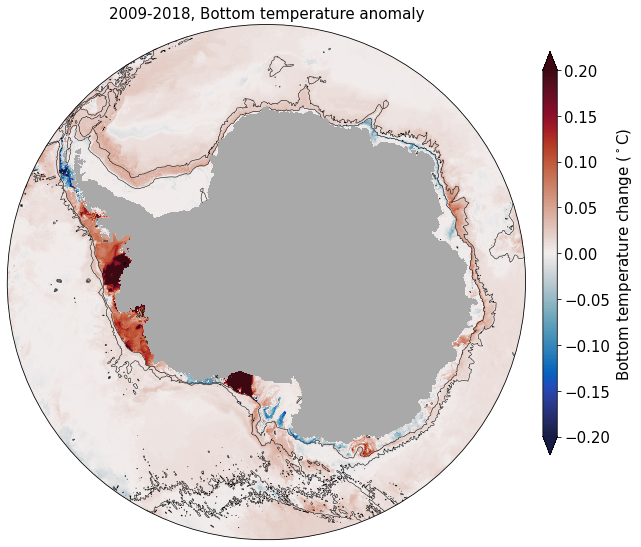

In [40]:
scale_max = .2

fig  = plt.figure(1, figsize = (8,8))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# setup stereo projection:
ax = fig.add_axes([0.0, 0.0, 0.9, .9],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(bottom_temp_con.xt_ocean, bottom_temp_con.yt_ocean, bottom_temp_melt-bottom_temp_con, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('2009-2018, Bottom temperature anomaly',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.93, 0.15, 0.025, 0.7])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Bottom temperature change ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

## Timeseries of abyssal temperature in Australian Antarctic Basin:

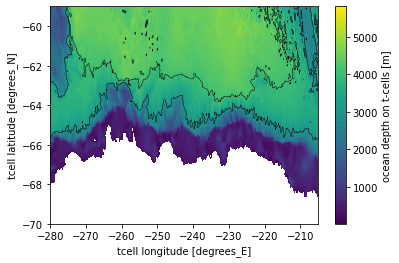

In [44]:
# first check region:

ht.plot()
plt.xlim(-280,-205)
plt.ylim(-70,-59)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[3000,4000],colors='k',linewidths=0.5)

lat_slice  = slice(-66,-59)
lon_slice  = slice(-280,-205)

In [45]:
# thickness / area for depth averaging (not time varying):

xt_ocean = cc.querying.getvar(control,'xt_ocean' , master_session,n=1)
yt_ocean = cc.querying.getvar(control,'yt_ocean' , master_session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_slice)
xt_ocean = xt_ocean.sel(xt_ocean=lon_slice)
# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(control, 'st_edges_ocean', master_session, n=1)
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean':yt_ocean,'xt_ocean':xt_ocean}, axis=[1,2])

# adjust edges at bottom for partial thickness:
ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
st_edges_with_partial = st_edges_array.where(st_edges_array<ht, other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(control, 'st_ocean', master_session, n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))

In [46]:
# area for area averaging:

area_t = cc.querying.getvar(control,'area_t',master_session,n=1)
area_t = area_t.where(ht>4000)
area_t = area_t.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

volume = area_t*thickness
volume = volume.load()
volume_sum = volume.sum()
volume_sum = volume_sum.load()

In [47]:
# whole time period:
start_time='1979-01-01'
end_time='2018-12-31'

# average below 4000m:
depth_slice  = slice(4000,6000)

temp_con = cc.querying.getvar(control, 'temp', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice)
# area and depth averaging in AAB (volume contains region mask):
temp_con = (temp_con*volume).sum('xt_ocean').sum('yt_ocean').sum('st_ocean')/volume_sum
temp_con = temp_con.load()

temp_melt = cc.querying.getvar(iaf_melt, 'temp', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_melt = temp_melt.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice)
temp_melt = (temp_melt*volume).sum('xt_ocean').sum('yt_ocean').sum('st_ocean')/volume_sum
temp_melt = temp_melt.load()

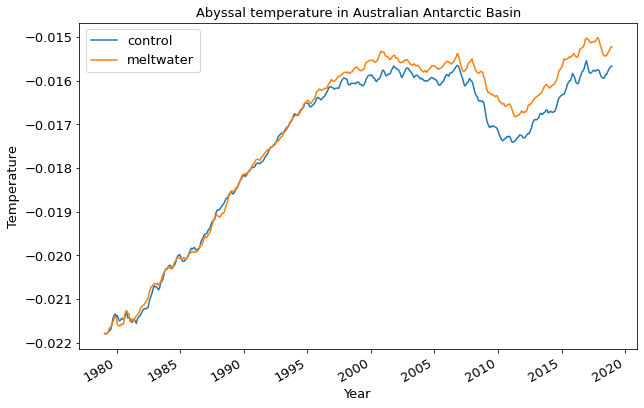

In [49]:
fontsize=13

plt.figure(figsize=(10,6))

temp_con.plot(label='control')
temp_melt.plot(label='meltwater')
plt.legend(fontsize=fontsize)
plt.title('Abyssal temperature in Australian Antarctic Basin',fontsize=fontsize)
plt.ylabel('Temperature',fontsize=fontsize)
plt.xlabel('Year',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)